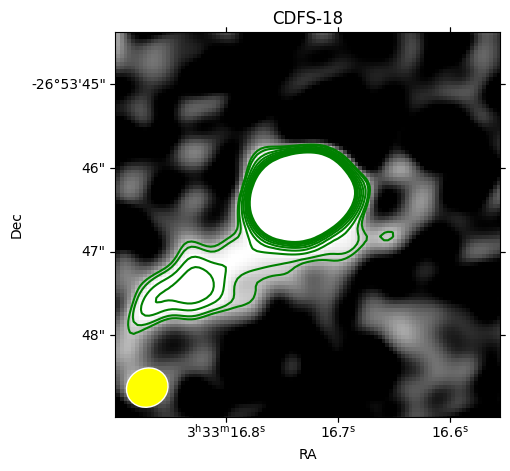

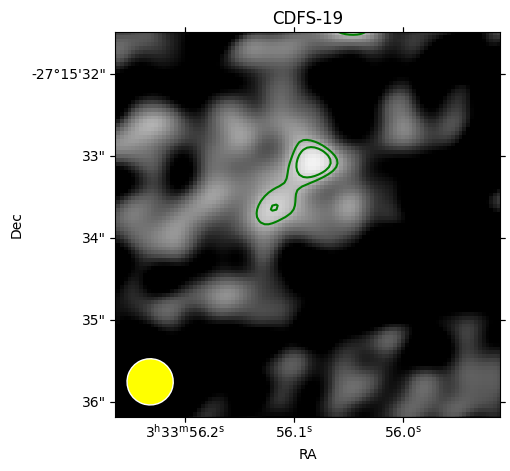

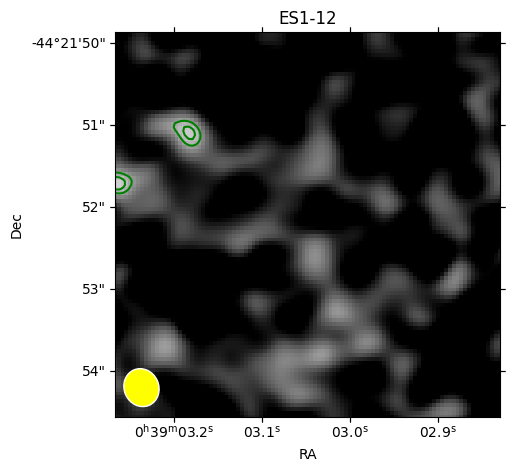

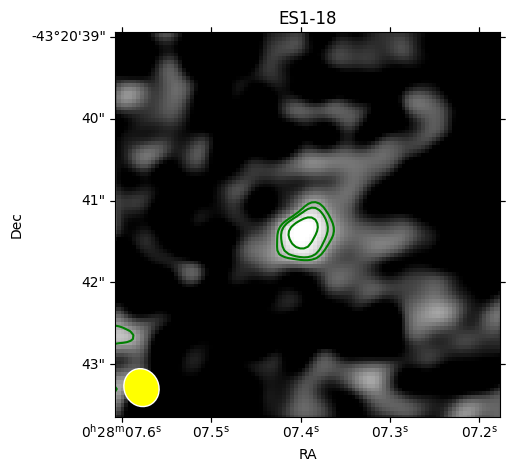

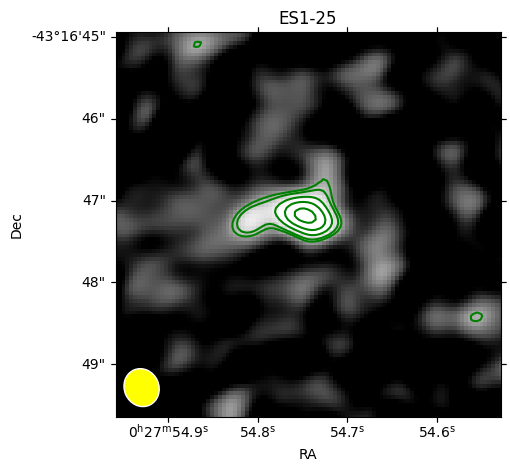

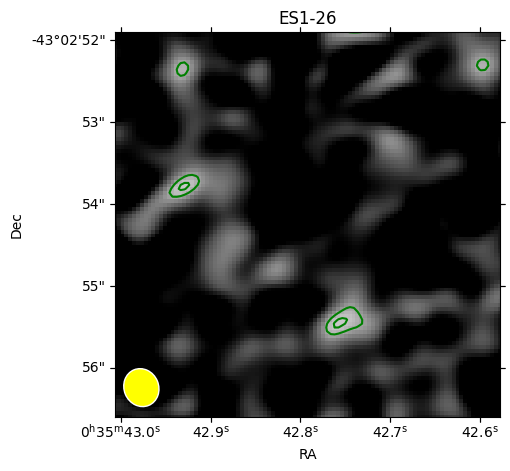

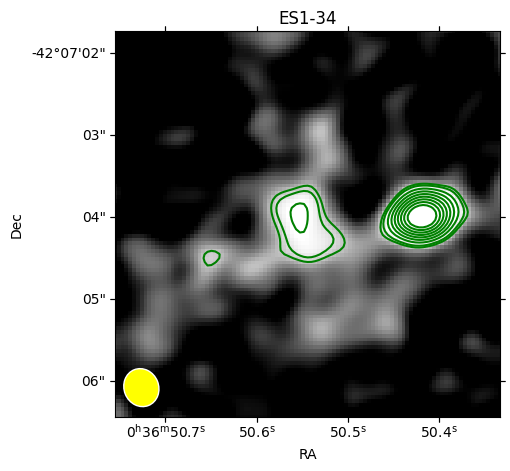

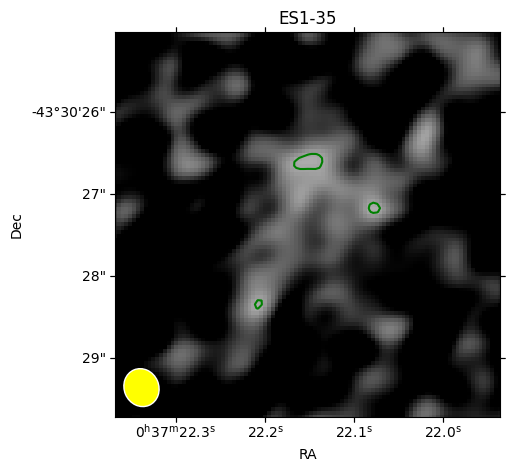

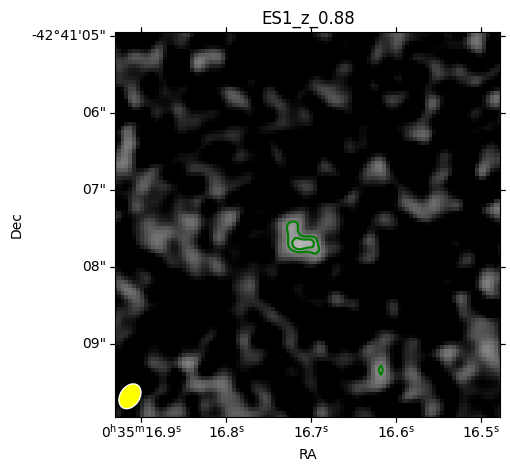

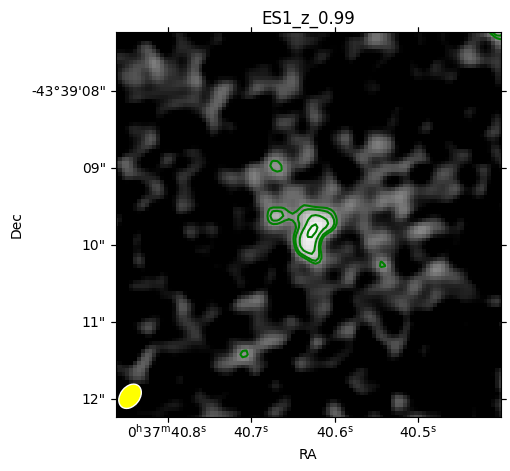

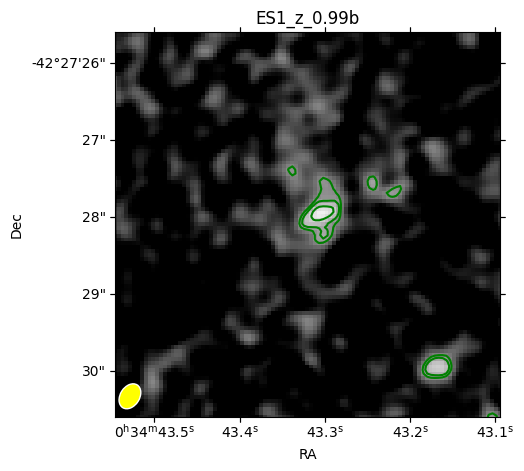

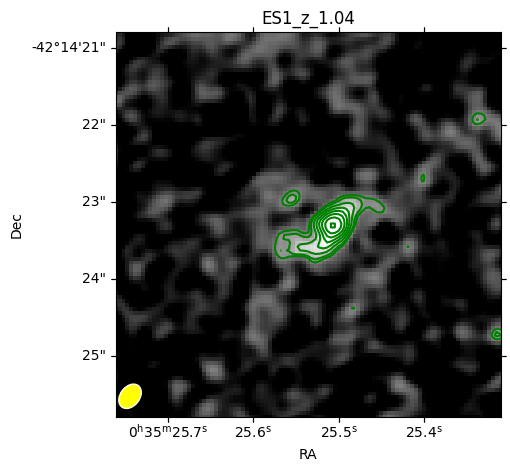

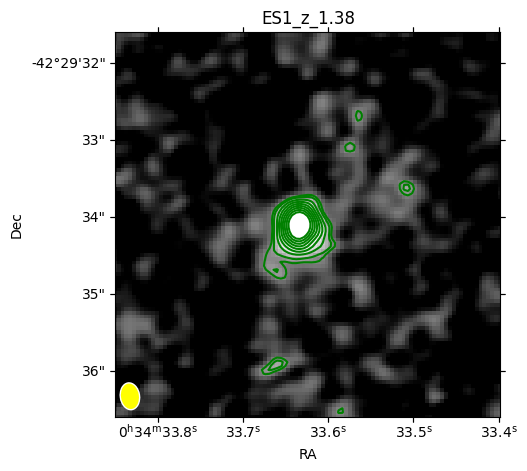

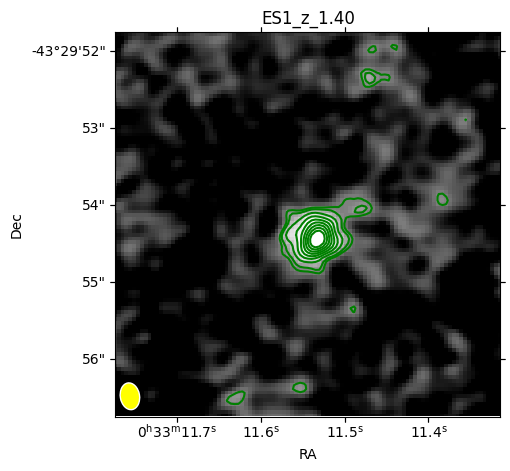

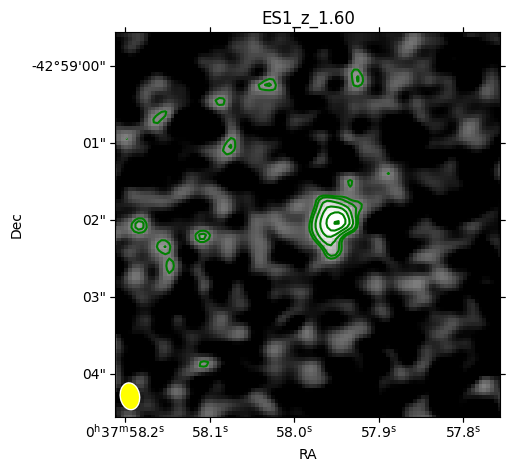

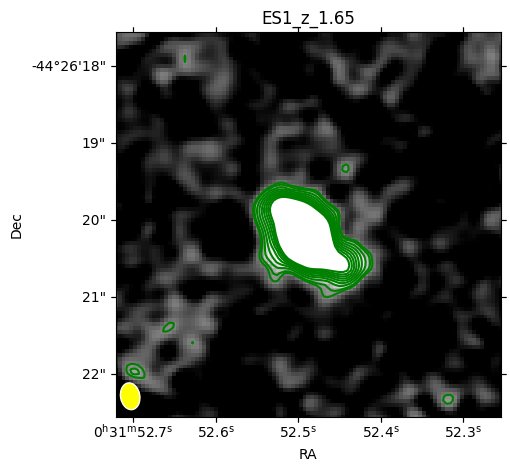

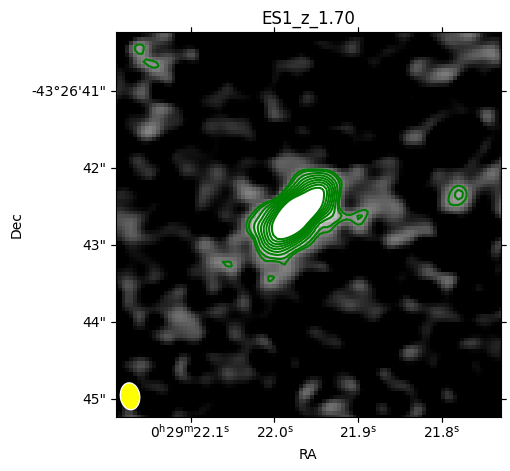

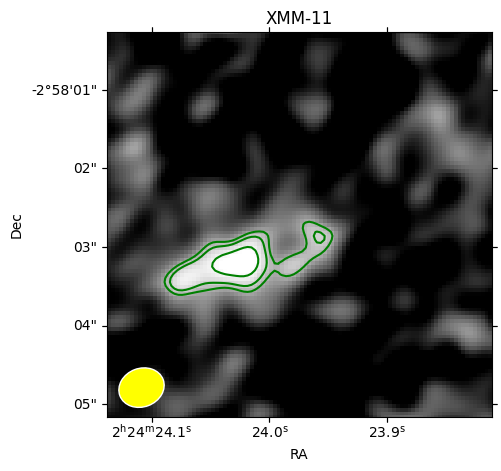

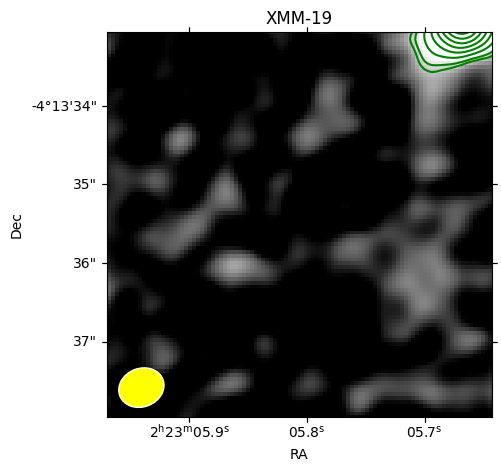

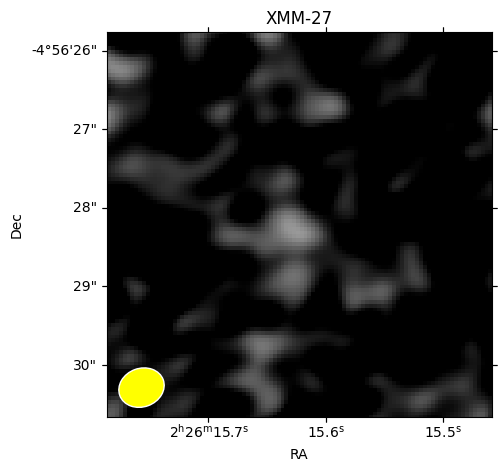

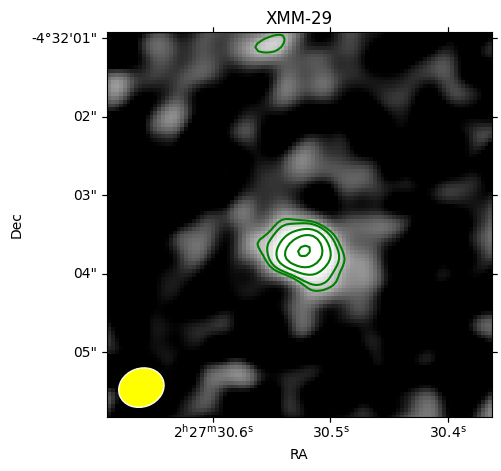

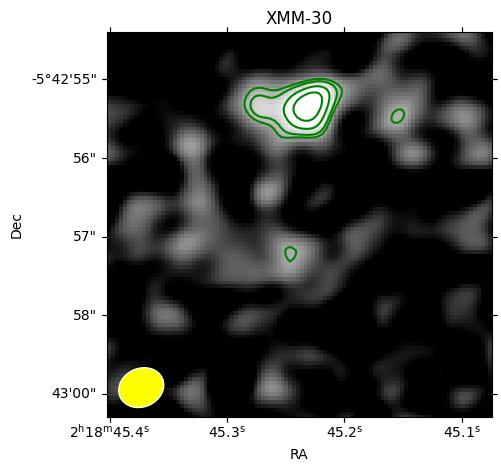

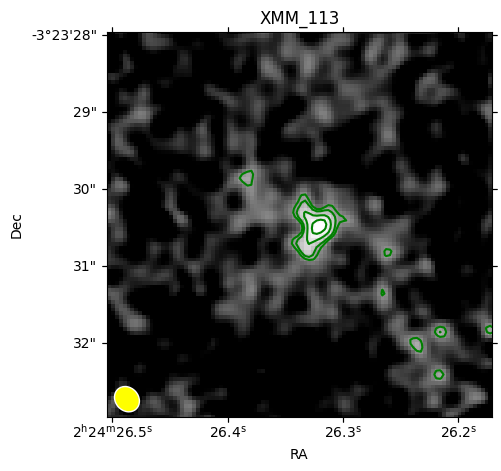

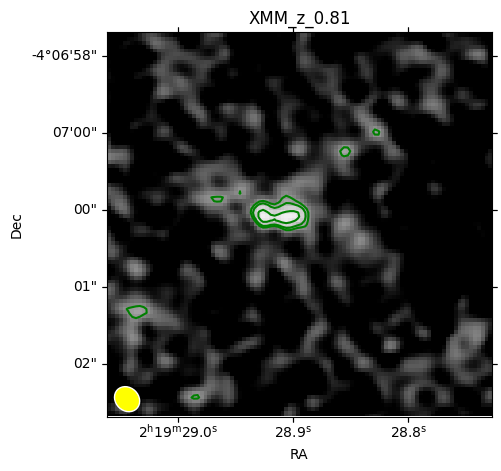

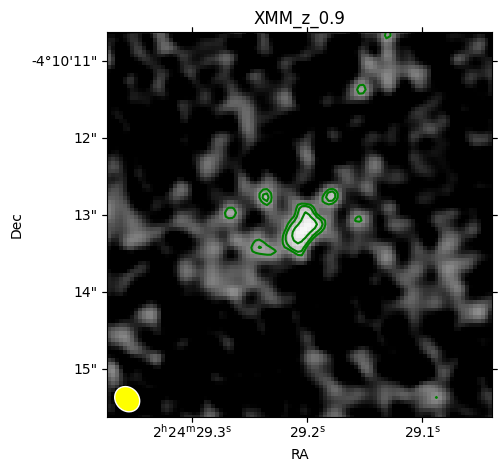

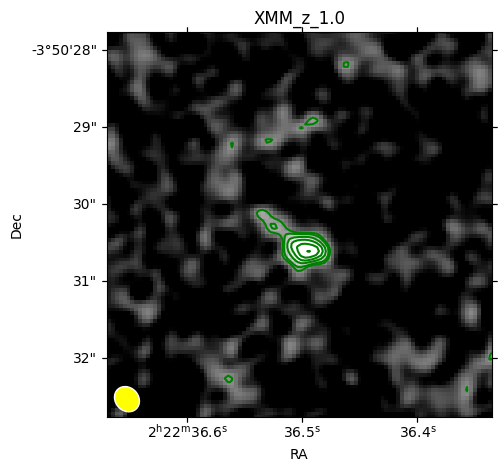

In [7]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.modeling.functional_models import Ellipse2D
from scipy.optimize import curve_fit
import glob
import pdb
from astropy.visualization import simple_norm, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization.stretch import LinearStretch, LogStretch
import warnings
warnings.filterwarnings('ignore')
plt.style.use(["default"])
#rms of alma bcg images
rms_dict = {'CDFS-18': 2.54e-05,'CDFS-19': 2.37e-05,'ES1_z_0.88': 1.79e-05,'ES1_z_0.99': 1.78e-05,'ES1_z_0.99b': 1.79e-05,'ES1_z_1.04': 1.69e-05,'ES1_z_1.38': 1.71e-05,'ES1_z_1.40': 1.65e-05,'ES1_z_1.60': 1.68e-05,'ES1_z_1.65': 1.72e-05,'ES1_z_1.70': 1.75e-05,'ES1-12': 2.15e-05,'ES1-18': 2.23e-05,'ES1-25': 2.2e-05,'ES1-26': 2.19e-05,'ES1-34': 2.6e-05,'ES1-35': 2.18e-05,'XMM_113': 1.9e-05,'XMM_z_0.81': 1.92e-05,'XMM_z_0.9': 1.9e-05,'XMM_z_1.0': 1.85e-05,'XMM-11': 2.3e-05,'XMM-19': 2.6e-05,'XMM-27': 2.2e-05,'XMM-29': 2.4e-05,'XMM-30': 2.21e-05}

 # sparcs z band coordinates
z_coords = {'CDFS-18': {'ra': 53.31966, 'dec': -26.89633},'CDFS-19': {'ra': 53.48372, 'dec': -27.25943},'XMM-11': {'ra': 36.0999, 'dec': -2.96742},'XMM-19': {'ra': 35.7742, 'dec': -4.22653},'XMM-27': {'ra': 36.56509, 'dec': -4.94118},'XMM-29': {'ra': 36.87717, 'dec': -4.53427},'XMM-30': {'ra': 34.68846, 'dec': -5.71579},'ES1-12': {'ra': 9.76266, 'dec': -44.36449},'ES1-18': {'ra': 7.03082, 'dec': -43.34483},'ES1-25': {'ra': 6.97814, 'dec': -43.2798},'ES1-26': {'ra': 8.92828, 'dec': -43.04841},'ES1-34': {'ra': 9.21062, 'dec': -42.11781},'ES1-35': {'ra': 9.34235, 'dec': -43.50759},'XMM_z_0.81': {'ra': 34.87042, 'dec': -4.11672},'XMM_z_0.9': {'ra': 36.1217, 'dec': -4.17031},'XMM_z_1.0': {'ra': 35.6521, 'dec': -3.84174},'XMM_113': {'ra': 36.10969, 'dec': -3.39178},'ES1_z_0.88': {'ra': 8.81961, 'dec': -42.68544},'ES1_z_0.99': {'ra': 9.41931, 'dec': -43.6527},'ES1_z_0.99b': {'ra': 8.68045, 'dec': -42.45776},'ES1_z_1.04': {'ra': 8.8564, 'dec': -42.23985},'ES1_z_1.38': {'ra': 8.64012, 'dec': -42.49283},'ES1_z_1.40': {'ra': 8.29814, 'dec': -43.49844},'ES1_z_1.60': {'ra': 9.49156, 'dec': -42.98388},'ES1_z_1.65': {'ra': 7.96871, 'dec': -44.43894},'ES1_z_1.70': {'ra': 7.34152, 'dec': -43.44523}}

# Storing the image paths as list
alma_images = sorted(glob.glob("/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/all_ALMA/*.fits"))
sparcs_images = sorted(glob.glob("/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/SpARCS_z/*.fits"))
mips_images = sorted(glob.glob("/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/IRAC/mips_24_micron/*.fits"))
irac_images = sorted(glob.glob("/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/IRAC/irac_3.6_micron/*.fits"))

# Function for creating the postage stamps
def plotting_stamps(z_band, irac, mips, alma, name):
    """
    z_band : path to z-band image
    irac: path to irac 3.6 micron image
    mips : path to 24 micron mips image
    alma : path to alma image
    """
    # opening all the fits images and processing
    def image_processing(image, img_type = None):
        hdu = fits.open(image)[0]
        if img_type == 'alma':
            header = hdu.header
            data = hdu.data[0,0,:,:]
            wcs = WCS(header, naxis = 2)
        else:
            header = hdu.header
            data = hdu.data
            wcs = WCS(header)
        data[np.where(np.isnan(data))] = 0
#         data /= np.amax(data)
        return header, data, wcs
    
#     header_z, data_z, wcs_z = image_processing(z_band)
#     header_irac, data_irac, wcs_irac = image_processing(irac)
#     header_mips, data_mips, wcs_mips = image_processing(mips)
    header_alma, data_alma, wcs_alma = image_processing(alma, 'alma')

    fig = plt.figure(figsize = (5,5))
    ax1 = fig.add_subplot(projection=wcs_alma)
#    ax2 = fig.add_subplot(142, projection=wcs_alma,sharey=ax1)
#    ax3 = fig.add_subplot(143, projection=wcs_alma,sharey=ax1)
#    ax4 = fig.add_subplot(144, projection=wcs_alma,sharey=ax1)

#    z_trans = ax1.get_transform(wcs_z)
#    irac_trans = ax2.get_transform(wcs_irac)
#    mips_trans = ax3.get_transform(wcs_mips)

    fwhm_maj = header_alma['BMAJ']*u.deg
    fwhm_min = header_alma['BMIN']*u.deg
    pa = header_alma['BPA'] + 90
    ra = header_alma['CRVAL1']*u.deg
    dec = header_alma['CRVAL2']*u.deg

    center = SkyCoord(ra, dec, frame = 'fk5')
    extent = SkyCoord(ra - fwhm_maj, dec + fwhm_min, frame='fk5')
    centerpix = wcs_alma.world_to_pixel(center)
    extpix = wcs_alma.world_to_pixel(extent)

    xlim = (centerpix[0]-50,centerpix[0]+50)
    ylim = (centerpix[1]-50,centerpix[1]+50)

    arad, brad = int(extpix[0] - centerpix[0]), int(extpix[1] - centerpix[1])
    beam1 = Ellipse((xlim[0]+arad*0.75, ylim[0]+brad*0.75),width=arad, height=brad, angle=pa, facecolor='yellow', edgecolor='white', zorder=11)
#    beam2 = Ellipse((xlim[0]+arad*0.75, ylim[0]+brad*0.75),width=arad, height=brad, angle=pa, facecolor='yellow', edgecolor='white', zorder=11)
#    beam3 = Ellipse((xlim[0]+arad*0.75, ylim[0]+brad*0.75),width=arad, height=brad, angle=pa, facecolor='yellow', edgecolor='white', zorder=11)
#    beam4 = Ellipse((xlim[0]+arad*0.75, ylim[0]+brad*0.75),width=arad, height=brad, angle=pa, facecolor='yellow', edgecolor='white', zorder=11)
    if name.startswith("XMM"):
        vmax = 80
    else:
        vmax = 300
#    z_coord = SkyCoord(ra = z_coords[name]['ra']*u.degree, dec = z_coords[name]['dec']*u.degree, frame = 'icrs')
#    z_pix = wcs_alma.world_to_pixel(z_coord)
#    im1 = ax1.imshow(data_z, transform = z_trans, origin = 'lower', interpolation='None',cmap = 'Greys_r',vmin = 0, vmax = vmax)
#    ax1.contour(data_alma, levels=np.array([2,3,4,5,6,7,8,9,10])*rms_dict[name], colors='red', linewidths = 0.5, zorder = 1)
#    ax1.scatter(centerpix[0], centerpix[1], marker = '+', color = 'blue', linewidth = 1, label = "3.6 micron")
#    ax1.scatter(z_pix[0], z_pix[1], marker = '+', color = 'green', zorder = 4, label = "Z band")

#    im2 = ax2.imshow(data_irac, transform = irac_trans, origin = 'lower', interpolation='None',cmap = 'Greys_r',vmin = 0, vmax = 1)
#    ax2.contour(data_alma, levels=np.array([2,3,4,5,6,7,8,9,10])*rms_dict[name], colors='red', linewidth = 1, zorder = 1)
#    ax2.scatter(centerpix[0], centerpix[1], marker = '+', color = 'blue', linewidth = 1)
#
#    im3 = ax3.imshow(data_mips, transform = mips_trans, origin = 'lower', interpolation='None',cmap = 'Greys_r',vmin = 0, vmax = 0.3)
#    ax3.contour(data_alma, levels=np.array([2,3,4,5,6,7,8,9,10])*rms_dict[name], colors='red', linewidth = 1, zorder = 1)
#    ax3.scatter(centerpix[0], centerpix[1], marker = '+', color = 'blue', linewidth = 1)
#
    im4 = ax1.imshow(data_alma, origin = 'lower', interpolation='None',cmap = 'Greys_r',vmin = 0, vmax = 0.0001)
    ax1.contour(data_alma, levels=np.array([2.5,3,4,5,6,7,8,9,10])*rms_dict[name], colors='green', linewidth = 1, zorder = 1, alpha = 1)
#    ax4.scatter(centerpix[0], centerpix[1], marker = '+', color = 'blue', linewidth = 1)
#
#    legend = ax1.legend()
    ax1.add_patch(beam1)
#    ax2.add_patch(beam2)
#    ax3.add_patch(beam3)
#    ax4.add_patch(beam4)
    ax1.set_ylabel("Dec")
    ax1.set_xlabel("RA")
#    ax2.set_xlabel("RA")
#    ax3.set_xlabel("RA")
#    ax4.set_xlabel("RA")
#    ax2.coords[1].set_ticks_visible(False)
#    ax2.coords[1].set_ticklabel_visible(False)
#    ax3.coords[1].set_ticks_visible(False)
#    ax3.coords[1].set_ticklabel_visible(False)
#    ax4.coords[1].set_ticks_visible(False)
#    ax4.coords[1].set_ticklabel_visible(False)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
#    ax2.set_xlim(xlim)
#    ax2.set_ylim(ylim)
#    ax3.set_xlim(xlim)
#    ax3.set_ylim(ylim)
#    ax4.set_xlim(xlim)
#    ax4.set_ylim(ylim)
    ax1.set_title(name)
#    ax2.set_title("IRAC 3.6 $\mu$m")
#    ax3.set_title("MIPS 24 $\mu$m")
#    ax4.set_title("ALMA 1.2 mm")
#    fig.suptitle(name)
#     fig.savefig("/Users/arames52/Desktop/Primary Project/postage_stamps/" + name + "_alma.jpg",bbox_inches ='tight')


for z, irac, mips, alma in zip(sparcs_images, irac_images, mips_images, alma_images):
    name = alma.split("/")[-1].split("_ALMA.fits")[0]
    bcgs = ["XMM_113", "XMM_z_1.0", "ES1-25", "ES1_z_1.40", "XMM-11", "XMM-29", "ES1_z_0.99", "ES1_z_1.04"]
    plotting_stamps(z, irac, mips, alma, name, bcgs)


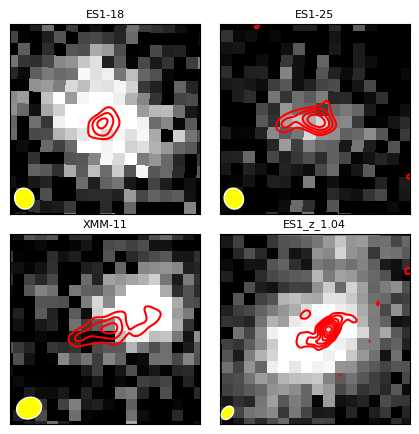

In [73]:
def image_processing(image, img_type = None):
    hdu = fits.open(image)[0]
    if img_type == 'alma':
        header = hdu.header
        data = hdu.data[0,0,:,:]
        wcs = WCS(header, naxis = 2)
    else:
        header = hdu.header
        data = hdu.data
        wcs = WCS(header)
    data[np.where(np.isnan(data))] = 0
#         data /= np.amax(data)
    return header, data, wcs
alma_images = sorted(glob.glob("/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/all_ALMA/*.fits"))
bcgs = ["ES1-18","ES1-25","XMM-11", "ES1_z_1.04"]
fig = plt.figure(figsize = (5,5))
for bcg,ind in zip(bcgs, range(len(bcgs))):
    alma = "/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/all_ALMA/" + bcg + "_ALMA.fits"
    z_band = "/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/SpARCS_z/" + bcg + ".fits"
    name = bcg
    header_alma, data_alma, wcs_alma = image_processing(alma, 'alma')
    header_z,data_z, wcs_z = image_processing(z_band)
    fwhm_maj = header_alma['BMAJ']*u.deg
    fwhm_min = header_alma['BMIN']*u.deg
    pa = header_alma['BPA'] + 90
    if name == "XMM-11":
        ra = 36.1001405*u.deg
        dec = -2.9675572*u.deg
    elif name == "XMM-29":
        ra = 36.8771832 * u.deg
        dec = -4.5343695 * u.deg
    elif name == 'ES1-25':
        ra = 6.9781257*u.deg
        dec = -43.2797621*u.deg
    else:
        ra = header_alma['CRVAL1']*u.deg
        dec = header_alma['CRVAL2']*u.deg
    
    center = SkyCoord(ra, dec, frame = 'fk5')
    extent = SkyCoord(ra - fwhm_maj, dec + fwhm_min, frame='fk5')
    centerpix = wcs_alma.world_to_pixel(center)
    extpix = wcs_alma.world_to_pixel(extent)

    xlim = (centerpix[0]-45,centerpix[0]+45)
    ylim = (centerpix[1]-45,centerpix[1]+45)
    arad, brad = int(extpix[0] - centerpix[0]), int(extpix[1] - centerpix[1])
    beam1 = Ellipse((xlim[0]+arad*0.75, ylim[0]+brad*0.75),width=arad, height=brad, angle=pa, facecolor='yellow', edgecolor='white', zorder=11)
    if name.startswith("XMM"):
        vmax = 80
    else:
        vmax = 200
    ax = fig.add_subplot(2,2,ind+1,projection = WCS(header_alma, naxis = 2))
    z_trans = ax.get_transform(WCS(header_z))
    im1 = ax.imshow(data_z, origin = 'lower', transform = z_trans, interpolation='None',cmap = 'Greys_r',vmin = 0, vmax = vmax)
    ax.contour(data_alma, levels=np.array([2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5])*rms_dict[name], colors='red', linewidth = 1, zorder = 1, alpha = 1)
    
    ax.add_patch(beam1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(name, size = 8, y = 0.99)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lon.set_ticklabel_visible(False)
    lat.set_ticks_visible(False)
    lat.set_ticklabel_visible(False)
    lon.set_axislabel('')
    lat.set_axislabel('')
plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.1)
fig.savefig("/Users/arames52/Desktop/Primary Project/postage_stamps/z_band_alma_contours.jpg", dpi = 300)

In [2]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle, Ellipse, Circle, Arrow
from astropy.modeling.functional_models import Ellipse2D
from scipy.optimize import curve_fit
import glob
import pdb
from astropy.visualization import simple_norm, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization.stretch import LinearStretch, LogStretch

In [3]:
BCGs = ['CDFS-18','CDFS-19','ES1-12','ES1-18','ES1-25','ES1-26','ES1-34','ES1-35',
'ES1_z_0.88','ES1_z_0.99','ES1_z_0.99b','ES1_z_1.04','ES1_z_1.38','ES1_z_1.40','ES1_z_1.60',
'ES1_z_1.65','ES1_z_1.70','XMM-11','XMM-19','XMM-27','XMM-29','XMM-30','XMM_113',
'XMM_z_0.81','XMM_z_0.9','XMM_z_1.0']
RMS = [0.0000218,0.0000218,0.0000215,0.0000203,0.0000192,0.0000227,0.0000217,0.0000197,
0.0000161,0.0000158,0.0000164,0.000015,0.0000154,0.0000165,0.0000158658,0.0000163,0.0000174,
0.0000219,0.0000202,0.000018,0.0000212,0.00002,0.0000175,0.0000168,0.0000178,0.000018]
S_max = [0.00386,0.0000898,0.0000645,0.00011,0.000141,0.0000681,0.000312,0.0000577,
0.0000606,0.0000943,0.0000876,0.000152,0.000221,0.000192,0.0001181054,0.000983,0.000288,
0.000114,0.0000606,0.000054,0.000147,0.00013,0.000106,0.0000874,0.0000942,0.00013]

In [4]:
redshift = [0.813, 0.69484, 0.74, 0.8068, 1.08807, 0.85192, 1.7, 1.7, 0.56395, 1.19372, 0.9188, 1.04, 
            1.38, 1.4, 1.6, 1.65, 1.7, 0.79, 1.04789, 1.38, 1.45, 1.45, 1.6, 0.7827207, 0.84957, 0.5352355]

In [5]:
rms_dict = {}
smax_dict = {}
z_dict = {}
for key,value1, value2, value3 in zip(BCGs, RMS, S_max, redshift):
    rms_dict[key] = value1
    smax_dict[key] = value2
    z_dict[key] = value3

alma_images = sorted(glob.glob("/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/all_ALMA/*.fits"))
sparcs_images = sorted(glob.glob("/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/SpARCS_z/*.fits"))

In [6]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
# 1/(0.045*(cosmo.kpc_proper_per_arcmin(1)/60)).value

In [7]:
def image_processing(image_path, name, img_type):
    hdu = fits.open(image_path)[0]
    if img_type == 'alma':
        data = hdu.data[0,0,:,:]
        header = hdu.header
        wcs = WCS(header, naxis = 2)
    elif img_type == 'z':
        data = hdu.data
        header = hdu.header
        wcs = WCS(header)
    data[np.where(np.isnan(data))] = 0
    return data,header,wcs

In [8]:
contour_levels = {}

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


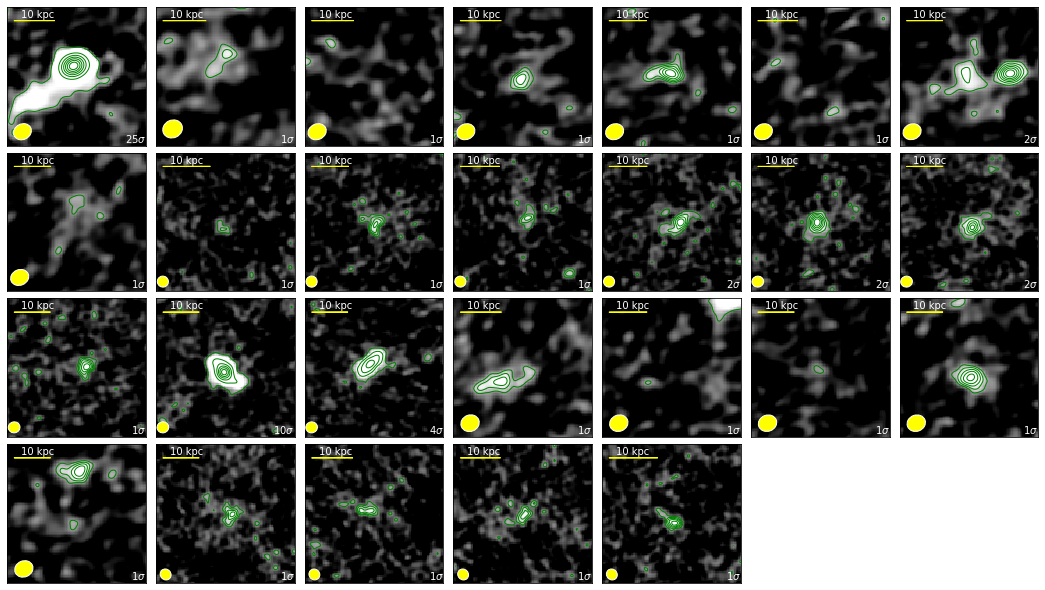

In [90]:
fig = plt.figure(figsize = (18,10))
for alma in alma_images:
    name = alma.split("/")[-1].split("_ALMA.fits")[0]
    data, header, wcs = image_processing(alma, name, 'alma')
    ax = fig.add_subplot(4,7, alma_images.index(alma)+1, projection = wcs)
    
    bmaj = header['BMAJ']*u.deg.to(u.arcsec)/0.045
    bmin = header['BMIN']*u.deg.to(u.arcsec)/0.045
    fwhm_maj = header['BMAJ']*u.deg
    fwhm_min = header['BMIN']*u.deg
    pa = header['BPA'] + 90
    ra = header['CRVAL1']*u.deg
    dec = header['CRVAL2']*u.deg

    center = SkyCoord(ra, dec, frame = 'fk5')
    extent = SkyCoord(ra - fwhm_maj, dec + fwhm_min, frame='fk5')
    centerpix = wcs.world_to_pixel(center)
    extpix = wcs.world_to_pixel(extent)

    xlim = (centerpix[0]-50,centerpix[0]+50)
    ylim = (centerpix[1]-50,centerpix[1]+50)

    arad, brad = int(extpix[0] - centerpix[0]), int(extpix[1] - centerpix[1])
    beam = Ellipse((xlim[0]+arad, ylim[0]+brad),width=bmaj, height=bmin, angle=pa, facecolor='yellow', edgecolor='white', zorder=11)
    
    levels = np.arange(rms_dict[name]*2.5, smax_dict[name], contour_steps[name]*rms_dict[name], dtype=None)
    steps = contour_steps[name]
    
    length = 10*(1/(0.045*(cosmo.kpc_proper_per_arcmin(z_dict[name])/60))).value
    kpc_line = Arrow(x = xlim[0] + 5, y = ylim[1]-10, dx = length, dy = 0.05, width = 0.5, color = 'yellow')
    line_text = "10 kpc"
    ax.text(0.1, 0.98, line_text, horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes, color = 'white', alpha = 1)
    text = str(round(steps,2)) + "$\sigma$"
    ax.imshow(data, origin = 'lower', cmap = 'Greys_r', interpolation = 'None', vmin = 0, vmax = 0.0001)
    ax.contour(data, levels = levels, colors='green', linewidths = 1, zorder = 1, alpha = 1)
    ax.add_patch(beam)
    ax.add_patch(kpc_line)
    ax.text(1, 0.01, text,
            horizontalalignment='right', verticalalignment='bottom',
            transform=ax.transAxes, color = 'white', alpha = 1)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lon.set_ticklabel_visible(False)
    lat.set_ticks_visible(False)
    lat.set_ticklabel_visible(False)
    lon.set_axislabel('')
    lat.set_axislabel('')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.03,
                    hspace=0.05)
fig.savefig("/Users/arames52/Desktop/test_alma.jpg", dpi = 400, bbox_inches = 'tight')
plt.show()

In [72]:
weak_detections = ['CDFS-19', 'ES1-12', 'ES1-26', 'ES1-35', 'XMM-19', 'XMM-27']
significant_detections = ['CDFS-18', 'ES1-18', 'ES1-25', 'ES1-34', 'ES1_z_0.88','ES1_z_0.99',
                          'ES1_z_0.99b', 'ES1_z_1.04', 'ES1_z_1.38', 'ES1_z_1.40','ES1_z_1.60',
                          'ES1_z_1.65', 'ES1_z_1.70', 'XMM-11','XMM-29','XMM-30','XMM_113',
                          'XMM_z_0.81','XMM_z_0.9','XMM_z_1.0']
high_sn_detections = ['CDFS-18', 'ES1_z_1.65', 'ES1_z_1.70']

In [84]:
contour_steps = {'CDFS-18':25, 'CDFS-19':1, 'ES1-12':1,'ES1-26':1, 'ES1-35':1, 'XMM-19':1, 'XMM-27':1,
                'ES1-18':1, 'ES1-25':1, 'ES1_z_0.88':1, 'ES1_z_0.99':1, 'ES1_z_0.99b':1, 
                'ES1_z_1.60':1, 'XMM-11':1, 'XMM-29':1, 'XMM-30':1,'XMM_113':1, 'XMM_z_0.81':1, 
                'XMM_z_0.9':1, 'XMM_z_1.0':1, 'ES1-34':2, 'ES1_z_1.04':2, 'ES1_z_1.38':2, 'ES1_z_1.40':2,
                'ES1_z_1.70':4, 'ES1_z_1.65':10}

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


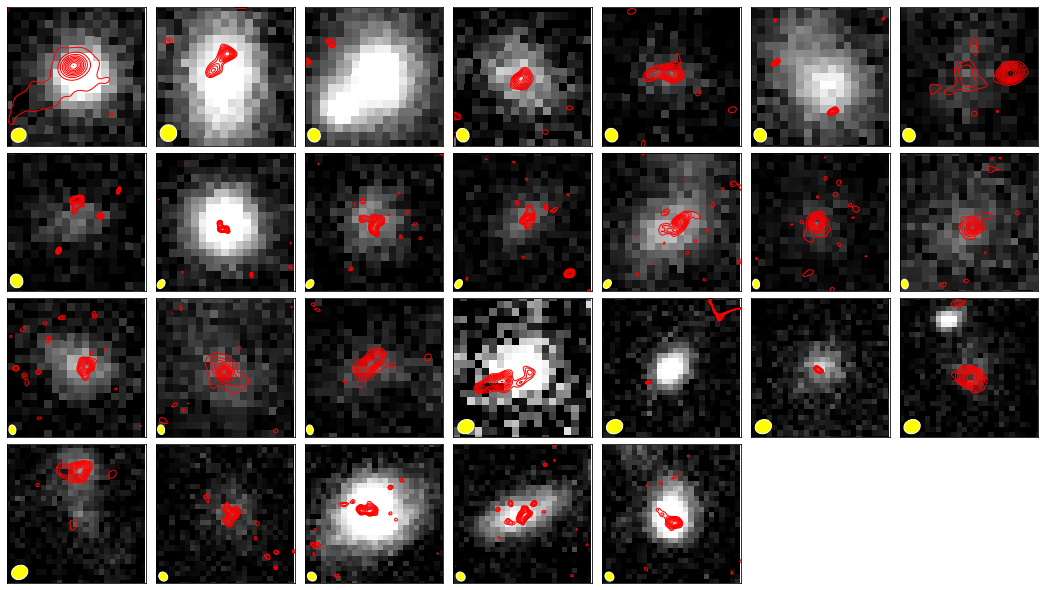

In [34]:
fig = plt.figure(figsize = (18,10))
for alma, sparcs in zip(alma_images, sparcs_images):
    name = alma.split("/")[-1].split("_ALMA.fits")[0]
    alma_data, alma_header, alma_wcs = image_processing(alma, name, 'alma')
    z_data, z_header, z_wcs = image_processing(sparcs, name, 'z')
    ax = fig.add_subplot(4,7, alma_images.index(alma)+1, projection = alma_wcs)
    fwhm_maj = alma_header['BMAJ']*u.deg
    fwhm_min = alma_header['BMIN']*u.deg
    pa = alma_header['BPA'] + 90
    ra = alma_header['CRVAL1']*u.deg
    dec = alma_header['CRVAL2']*u.deg

    center = SkyCoord(ra, dec, frame = 'fk5')
    extent = SkyCoord(ra - fwhm_maj, dec + fwhm_min, frame='fk5')
    centerpix = alma_wcs.world_to_pixel(center)
    extpix = alma_wcs.world_to_pixel(extent)

    xlim = (centerpix[0]-50,centerpix[0]+50)
    ylim = (centerpix[1]-50,centerpix[1]+50)

    arad, brad = int(extpix[0] - centerpix[0]), int(extpix[1] - centerpix[1])
    beam = Ellipse((xlim[0]+arad*0.75, ylim[0]+brad*0.75),width=arad, height=brad, angle=pa, facecolor='yellow', edgecolor='white', zorder=11)
    levels = np.linspace(rms_dict[name]*2.5, smax_dict[name], 10)
    
    if name.startswith("XMM"):
        vmax = 50
    else:
        vmax = 400
    ax.contour(alma_data, levels = levels, colors='red', linewidths = 1, zorder = 1, alpha = 1) 
    trans = ax.get_transform(z_wcs)
    ax.imshow(z_data, origin = 'lower', transform = trans, cmap = 'Greys_r', interpolation = 'None', vmin = 0, vmax = vmax)
    ax.add_patch(beam)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lon.set_ticklabel_visible(False)
    lat.set_ticks_visible(False)
    lat.set_ticklabel_visible(False)
    lon.set_axislabel('')
    lat.set_axislabel('') 
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.03,
                    hspace=0.05)
fig.savefig("/Users/arames52/Desktop/z_band_alma_contours.jpg", dpi = 400)
plt.show()

In [35]:
76/(0.4*320)

0.59375

In [36]:
ax[3].plot(xcs, ycs, 'ro', markersize=5, label='Sérsic Center')
R = float(nx**2 + ny**2)
theta = morph1.sersic_theta
x0, x1 = xcs - R*np.cos(theta), xcs + R*np.cos(theta)
y0, y1 = ycs - R*np.sin(theta), ycs + R*np.sin(theta)
ax.plot([x0, x1], [y0, y1], 'r--', lw=1.5, label='Major Axis (Sérsic)')
# Half-radius ellipse
a = morph1.sersic_rhalf
b = a * (1.0 - morph1.sersic_ellip)
xprime, yprime = a*np.cos(theta_vec), b*np.sin(theta_vec)
x = xcs + (xprime*np.cos(theta) - yprime*np.sin(theta))
y = ycs + (xprime*np.sin(theta) + yprime*np.cos(theta))
ax[3].plot(x, y, 'r', label='Half-Light Ellipse (Sérsic)')
ax[3].set_xlim(-0.5, nx-0.5)
ax[3].set_ylim(-0.5, ny-0.5)

0.0033899999999999994

In [37]:
100*0.045

4.5